In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Gradient Boosting
import lightgbm as lgb
import xgboost as xgb

# Scikit-learn
from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Dataset
from sklearn.datasets import load_boston

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Uploading the Boston dataset
X, y = load_boston(return_X_y=True)

# Transforming the problem into a classification (unbalanced)
y_bin = (y > np.percentile(y, 90)).astype(int)

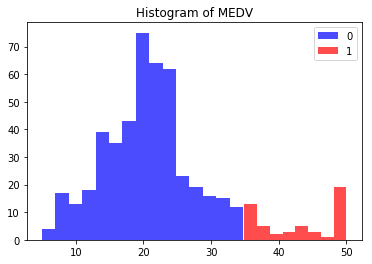

In [3]:
# Histogram highlighting the top 10% we use as a target
plt.hist(y[y <= np.percentile(y, 90)], bins='auto', alpha=0.7, label='0', color='b')
plt.hist(y[y > np.percentile(y, 90)], bins=8, alpha=0.7, label='1', color='r')
plt.title("Histogram of MEDV")
plt.legend(loc='upper right')
plt.show()

In [4]:
# For convenience, we will create a Pandas dataframe from X
train = pd.DataFrame(X)
train = train.add_prefix('var_')

In [5]:
# Checking about the shape of our training set
print(train.shape)

(506, 13)


In [27]:
# Setting a 5-fold stratified cross-validation (note: shuffle=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

In [28]:
MAX_ROUNDS = 2000
lgb_iter1 = []
sklearn_gbm_iter1 = []
xgb_gbm_iter1 = []

lgb_ap1 = []
sklearn_gbm_ap1 = []
xgb_gbm_ap1 = []

In [29]:
# Set up the classifier with standard configuration
# Later we will perform parameter tuning with Bayesian Optimization
params = {
    'learning_rate':  0.06, 
    'max_depth': 6, 
    #'lambda_l1': 16.7,
    'min_data_in_leaf':5,
    'boosting': 'gbdt', 
    'objective': 'binary', 
    'metric': 'auc',
    'feature_fraction': .9,
    'is_training_metric': False, 
    'seed': 1
}

In [30]:
for i, (train_index, test_index) in enumerate(skf.split(train,y_bin)):
    
    # Create data for this fold
    y_train, y_valid = y_bin[train_index], y_bin[test_index]
    X_train, X_valid = train.iloc[train_index,:], train.iloc[test_index,:]
        
    print( "\nFold ", i)

    # Running models for this fold
    
    # ->LightGBM
    lgb_gbm = lgb.train(params, 
                          lgb.Dataset(X_train, label=y_train), 
                          MAX_ROUNDS, 
                          lgb.Dataset(X_valid, label=y_valid), 
                          verbose_eval=False, 
                          #feval= auc, 
                          early_stopping_rounds=50)
    
    print( " Best iteration lgb = ", lgb_gbm.best_iteration)
    
    # ->Scikit-learn GBM
    sklearn_gbm = GradientBoostingClassifier(n_estimators=MAX_ROUNDS, 
                                    learning_rate = 0.06,
                                    max_features=2, 
                                    max_depth = 6, 
                                    n_iter_no_change=50, 
                                    tol=0.01,
                                    random_state = 0)
    
    sklearn_gbm.fit(X_train, y_train)
    print( " Best iteration sklearn_gbm = ", sklearn_gbm.n_estimators_)
    
    # ->XGBoost
    xgb_gbm = xgb.XGBClassifier(max_depth=6, 
                                n_estimators=MAX_ROUNDS,
                                eval_set=[(X_train, y_train), (X_valid, y_valid)],
                                learning_rate=0.06,
                                early_stopping_rounds=50)

    xgb_gbm.fit(X_train, y_train)
    
    print( " Best iteration xgboost_gbm = ", xgb_gbm.get_booster().best_iteration)
    
    # Storing and reporting results of the fold
    lgb_iter1 = np.append(lgb_iter1, lgb_gbm.best_iteration)
    sklearn_gbm_iter1 = np.append(sklearn_gbm_iter1, sklearn_gbm.n_estimators_)
    xgb_gbm_iter1 = np.append(xgb_gbm_iter1, xgb_gbm.get_booster().best_iteration)
   
    pred = lgb_gbm.predict(X_valid, num_iteration=lgb_gbm.best_iteration)
    ap = average_precision_score(y_valid, pred, average='macro', pos_label=1, sample_weight=None)
    print('lgb ', ap)
    lgb_ap1 = np.append(lgb_ap1, ap)
    
    pred = sklearn_gbm.predict(X_valid)
    ap = average_precision_score(y_valid, pred, average='macro', pos_label=1, sample_weight=None)
    print('sklearn_gbn ', ap)
    sklearn_gbm_ap1 = np.append(sklearn_gbm_ap1, ap)
    
    pred  = xgb_gbm.predict(X_valid)
    ap = average_precision_score(y_valid, pred, average='macro', pos_label=1, sample_weight=None)
    print('xgboost ', ap)
    xgb_gbm_ap1 = np.append(xgb_gbm_ap1, ap)


Fold  0
 Best iteration lgb =  12
 Best iteration sklearn_gbm =  63
 Best iteration xgboost_gbm =  1999
lgb  0.8092050493366283
sklearn_gbn  0.35953654188948314
xgboost  0.27641965877259994

Fold  1
 Best iteration lgb =  64
 Best iteration sklearn_gbm =  71
 Best iteration xgboost_gbm =  1999
lgb  0.7724999999999999
sklearn_gbn  0.37940594059405947
xgboost  0.4661716171617162

Fold  2
 Best iteration lgb =  118
 Best iteration sklearn_gbm =  137
 Best iteration xgboost_gbm =  1999
lgb  0.9022333222333222
sklearn_gbn  0.6422029702970297
xgboost  0.8333333333333334

Fold  3
 Best iteration lgb =  5
 Best iteration sklearn_gbm =  98
 Best iteration xgboost_gbm =  1999
lgb  1.0
sklearn_gbn  0.81990099009901
xgboost  0.9090909090909091

Fold  4
 Best iteration lgb =  15
 Best iteration sklearn_gbm =  74
 Best iteration xgboost_gbm =  1999
lgb  0.9500000000000001
sklearn_gbn  0.6396039603960396
xgboost  0.730913091309131


In [31]:
print('lgb_iter1: ', np.mean(lgb_iter1))
print('sklearn_gbm_iter1: ', np.mean(sklearn_gbm_iter1))
print('xgb_gbm_iter1: ',np.mean(xgb_gbm_iter1))

print('lgb_ap1: ', np.mean(lgb_ap1))
print('sklearn_gbm_ap1: ', np.mean(sklearn_gbm_ap1))
print('xgb_gbm_ap1: ', np.mean(xgb_gbm_ap1))

lgb_iter1:  42.8
sklearn_gbm_iter1:  88.6
xgb_gbm_iter1:  1999.0
lgb_ap1:  0.8867876743139901
sklearn_gbm_ap1:  0.5681300806551244
xgb_gbm_ap1:  0.643185721933538


In [33]:
poly = PolynomialFeatures(2)
poly_train = poly.fit_transform(train)

In [37]:
poly_train = pd.DataFrame(poly_train)

In [38]:
poly_train.head()

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,1.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,...,87616.0,4528.8,117482.40,1474.08,234.09,6072.570,76.194,157529.6100,1976.5620,24.8004
1,1.0,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,...,58564.0,4307.6,96049.80,2211.88,316.84,7064.820,162.692,157529.6100,3627.6660,83.5396
2,1.0,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,...,58564.0,4307.6,95064.86,975.26,316.84,6992.374,71.734,154315.4089,1583.1049,16.2409
3,1.0,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,...,49284.0,4151.4,87607.86,652.68,349.69,7379.581,54.978,155732.8369,1160.2122,8.6436
4,1.0,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,...,49284.0,4151.4,88111.80,1183.26,349.69,7422.030,99.671,157529.6100,2115.4770,28.4089


In [40]:
poly_train = poly_train.add_prefix('poly_')

In [41]:
train = pd.concat([train,poly_train], axis=1)

In [42]:
print(train.shape)
print(train.head())

(506, 118)
     var_0  var_1  var_2  var_3  var_4  var_5  var_6   var_7  var_8  var_9  \
0  0.00632   18.0   2.31    0.0  0.538  6.575   65.2  4.0900    1.0  296.0   
1  0.02731    0.0   7.07    0.0  0.469  6.421   78.9  4.9671    2.0  242.0   
2  0.02729    0.0   7.07    0.0  0.469  7.185   61.1  4.9671    2.0  242.0   
3  0.03237    0.0   2.18    0.0  0.458  6.998   45.8  6.0622    3.0  222.0   
4  0.06905    0.0   2.18    0.0  0.458  7.147   54.2  6.0622    3.0  222.0   

     ...     poly_95  poly_96    poly_97  poly_98  poly_99  poly_100  \
0    ...     87616.0   4528.8  117482.40  1474.08   234.09  6072.570   
1    ...     58564.0   4307.6   96049.80  2211.88   316.84  7064.820   
2    ...     58564.0   4307.6   95064.86   975.26   316.84  6992.374   
3    ...     49284.0   4151.4   87607.86   652.68   349.69  7379.581   
4    ...     49284.0   4151.4   88111.80  1183.26   349.69  7422.030   

   poly_101     poly_102   poly_103  poly_104  
0    76.194  157529.6100  1976.5620   2

In [43]:
MAX_ROUNDS = 2000
lgb_iter2 = []
sklearn_gbm_iter2 = []
xgb_gbm_iter2 = []

lgb_ap2 = []
sklearn_gbm_ap2 = []
xgb_gbm_ap2 = []

In [44]:
for i, (train_index, test_index) in enumerate(skf.split(train,y_bin)):
    
    # Create data for this fold
    y_train, y_valid = y_bin[train_index], y_bin[test_index]
    X_train, X_valid = train.iloc[train_index,:], train.iloc[test_index,:]
        
    print( "\nFold ", i)

    # Run model for this fold

    lgb_gbm = lgb.train(params, 
                          lgb.Dataset(X_train, label=y_train), 
                          MAX_ROUNDS, 
                          lgb.Dataset(X_valid, label=y_valid), 
                          verbose_eval=False, 
                          #feval= auc, 
                          early_stopping_rounds=50)
    
    print( " Best iteration lgb = ", lgb_gbm.best_iteration)
    
    sklearn_gbm = GradientBoostingClassifier(n_estimators=MAX_ROUNDS, 
                                    learning_rate = 0.06,
                                    max_features=2, 
                                    max_depth = 6, 
                                    n_iter_no_change=50, 
                                    tol=0.01,
                                    random_state = 0)
    
    sklearn_gbm.fit(X_train, y_train)
    print( " Best iteration sklearn_gbm = ", sklearn_gbm.n_estimators_)
    
    
    xgb_gbm = xgb.XGBClassifier(max_depth=6, 
                                n_estimators=MAX_ROUNDS,
                                eval_set=[(X_train, y_train), (X_valid, y_valid)],
                                learning_rate=0.06,
                                early_stopping_rounds=50)

    xgb_gbm.fit(X_train, y_train)
    
    print( " Best iteration xgboost_gbm = ", xgb_gbm.get_booster().best_iteration)
    
    lgb_iter2 = np.append(lgb_iter2, lgb_gbm.best_iteration)
    sklearn_gbm_iter2 = np.append(sklearn_gbm_iter2, sklearn_gbm.n_estimators_)
    xgb_gbm_iter2 = np.append(xgb_gbm_iter2, xgb_gbm.get_booster().best_iteration)
    
    pred = lgb_gbm.predict(X_valid, num_iteration=lgb_gbm.best_iteration)
    ap = average_precision_score(y_valid, pred, average='macro', pos_label=1, sample_weight=None)
    print('lgb ', ap)
    lgb_ap2 = np.append(lgb_ap2, ap)
    
    pred = sklearn_gbm.predict(X_valid)
    ap = average_precision_score(y_valid, pred, average='macro', pos_label=1, sample_weight=None)
    print('sklearn_gbn ', ap)
    sklearn_gbm_ap2 = np.append(sklearn_gbm_ap2, ap)
    
    pred  = xgb_gbm.predict(X_valid)
    ap = average_precision_score(y_valid, pred, average='macro', pos_label=1, sample_weight=None)
    print('xgboost ', ap)
    xgb_gbm_ap2 = np.append(xgb_gbm_ap2, ap)


Fold  0
 Best iteration lgb =  83
 Best iteration sklearn_gbm =  64
 Best iteration xgboost_gbm =  1999
lgb  0.7923602912239276
sklearn_gbn  0.35953654188948314
xgboost  0.3834988540870894

Fold  1
 Best iteration lgb =  120
 Best iteration sklearn_gbm =  86
 Best iteration xgboost_gbm =  1999
lgb  0.8226619132501486
sklearn_gbn  0.37940594059405947
xgboost  0.4661716171617162

Fold  2
 Best iteration lgb =  3
 Best iteration sklearn_gbm =  121
 Best iteration xgboost_gbm =  1999
lgb  0.9354365079365079
sklearn_gbn  0.4661716171617162
xgboost  0.6598019801980199

Fold  3
 Best iteration lgb =  55
 Best iteration sklearn_gbm =  97
 Best iteration xgboost_gbm =  1999
lgb  0.9909090909090909
sklearn_gbn  0.6598019801980199
xgboost  1.0

Fold  4
 Best iteration lgb =  13
 Best iteration sklearn_gbm =  88
 Best iteration xgboost_gbm =  1999
lgb  0.9572979797979797
sklearn_gbn  0.6396039603960396
xgboost  0.7297029702970297


In [45]:
print('lgb_iter1: ', np.mean(lgb_iter1),' lgb_iter2: ', np.mean(lgb_iter2))
print('sklearn_gbm_iter1: ', np.mean(sklearn_gbm_iter1), ' sklearn_gbm_iter2: ', np.mean(sklearn_gbm_iter2))
print('xgb_gbm_iter1: ',np.mean(xgb_gbm_iter1), ' xgb_gbm_iter2: ',np.mean(xgb_gbm_iter2) )

print('lgb_ap1: ', np.mean(lgb_ap1), ' lgb_ap2: ', np.mean(lgb_ap2))
print('sklearn_gbm_ap1: ', np.mean(sklearn_gbm_ap1), ' sklearn_gbm_ap2: ', np.mean(sklearn_gbm_ap2))
print('xgb_gbm_ap1: ', np.mean(xgb_gbm_ap1), ' xgb_gbm_ap2: ', np.mean(xgb_gbm_ap2))

lgb_iter1:  42.8  lgb_iter2:  54.8
sklearn_gbm_iter1:  88.6  sklearn_gbm_iter2:  91.2
xgb_gbm_iter1:  1999.0  xgb_gbm_iter2:  1999.0
lgb_ap1:  0.8867876743139901  lgb_ap2:  0.8997331566235308
sklearn_gbm_ap1:  0.5681300806551244  sklearn_gbm_ap2:  0.5009040080478637
xgb_gbm_ap1:  0.643185721933538  xgb_gbm_ap2:  0.647835084348771


Before we proceed with optimization, some important questions and insights about model specification.

1. Should we use all methods and mix them up in a competition?

2. Should we use all methods and mix them up in a work project?

3. Should we add the polynomial features in a competition?

4. Should we add the polynomial features in a work project?

# PART II : Optimizing hyper-parameters

The second topic of this workshop is also to illustrate how to best optimize the hyperparameters of a gradient boosting model (lightGBM before all, but also XGBoost and CatBoost) in a performing and efficient way. We will also compare the strong and weak points of different tuning approaches, such grid-search, random search and bayesian optimization by Scikit-optimize.

Leaving apart grid-search (feasible only when the space of experiments is limited), the usual choice for the practitioner is to apply random search optimization or try some Bayesian Optimization (BO) technique, which require a more complex setup.

As for as BO, there are quite a few choices (for instance Hyperopt) but we decided for Scikit-Optimize, or skopt, because it is a simple and efficient library to minimize (very) expensive and noisy black-box functions and it works with an API similar to Scikit-learn. It can be found at https://github.com/scikit-optimize/scikit-optimize/

In [50]:
# Assuring you have the most recent CatBoost release
!pip3 install catboost -U

Requirement already up-to-date: catboost in /anaconda3/lib/python3.6/site-packages (0.12.2)
You are using pip version 18.0, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [51]:
!pip3 install joblib

  Using cached https://files.pythonhosted.org/packages/49/d9/4ea194a4c1d0148f9446054b9135f47218c23ccc6f649aeb09fab4c0925c/joblib-0.13.1-py2.py3-none-any.whl
You are using pip version 18.0, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [52]:
# Importing core libraries
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Our example dataset
from sklearn.datasets import load_boston

# Classifiers
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# Hyperparameters distributions
from scipy.stats import randint
from scipy.stats import uniform

# Model selection
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# Metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt import gp_minimize # Bayesian optimization using Gaussian Processes
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args # decorator to convert a list of parameters to named arguments
from skopt.callbacks import DeadlineStopper # Stop the optimization before running out of a fixed budget of time.
from skopt.callbacks import VerboseCallback # Callback to control the verbosity
from skopt.callbacks import DeltaXStopper # Stop the optimization If the last two positions at which the objective has been evaluated are less than delta

In [53]:
# Uploading the Boston dataset
X, y = load_boston(return_X_y=True)

In [54]:
# Transforming the problem into a classification (unbalanced)
y_bin = (y > np.percentile(y, 90)).astype(int)

# Optimizing Scikit-learn GradientBoostingClassifier

GridSearchCV, RandomizedSearchCV (from Scikit-learn) and BayesSearchCV (from Scikit-optimize) all have the same API. A wrapper can just put together optimization, callbacks, best results reporting and time monitoring.

In [55]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    best_score = optimizer.best_score_
    best_score_std = optimizer.cv_results_['std_test_score'][optimizer.best_index_]
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [56]:
# Converting average precision score into a scorer suitable for model selection
avg_prec = make_scorer(average_precision_score, greater_is_better=True, needs_proba=True)

In [57]:
# Setting a 5-fold stratified cross-validation (note: shuffle=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [58]:
# A Scikit-learn GBM classifier
clf = GradientBoostingClassifier(n_estimators=20, random_state=0)

Grid search exhaustively searches through the hyperparameters and is not feasible in high dimensional space This is a very simple algorithm and suffers from the curse of dimensionality, though it's embarrassingly parallel.

Here we use, GridSearchCV, a function from Scikit-learn

In [59]:
# GridSearchCV needs a predefined plan of the experiments
grid_search = GridSearchCV(clf, 
                           param_grid={"learning_rate": [0.01, 1.0],
                                       "n_estimators": [10, 500],
                                       "subsample": [1.0, 0.5],
                                       "min_samples_split": [2, 10],
                                       "min_samples_leaf": [1, 10],
                                       "max_features": ['sqrt', 'log2', None]
                                       },
                           n_jobs=-1,
                           cv=skf,
                           scoring=avg_prec,
                           iid=False, # just return the average score across folds
                           return_train_score=False)

best_params = report_perf(grid_search, X, y_bin,'GridSearchCV')

GridSearchCV took 18.61 seconds,  candidates checked: 96, best CV score: 0.909 ± 0.072
Best parameters:
{'learning_rate': 0.01,
 'max_features': None,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 500,
 'subsample': 0.5}



Random search, which simply samples the search space randomly, is feasible in high dimensional spaces, and is widely used in practice. The downside of random search, however, is that it doesn’t use information from prior experiments to select the next setting.

You simply need to be lucky to catch the right hyper-parameters, or just try more ;-).

In fact, the 2×Random Search is the Random Search algorithm when it was allowed to sample two points for each point the other algorithms evaluated. While some authors have claimed that 2×Random Search is highly competitive with Bayesian Optimization methods, a study by Google (GOLOVIN, Daniel, et al. Google vizier: A service for black-box optimization. In: Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. ACM, 2017. p. 1487-1495) suggests that this is only true when the dimensionality of the problem is sufficiently high (e.g., over 16)

RandomizedSearchCV is a function from Scikit-learn, though skopt has it own random optimizer, dummy_minimize.

In [60]:
# RandomizedSearchCV needs the distribution of the experiments to be tested
# If you can provide the right distribution, the sampling will lead to faster and better results.

random_search = RandomizedSearchCV(clf, 
                                   param_distributions={"learning_rate": uniform(0.01, 1.0),
                                                        "n_estimators": randint(10, 500),
                                                        "subsample": uniform(0.5, 0.5),
                                                        "min_samples_split": randint(2, 10),
                                                        "min_samples_leaf": randint(1, 10),
                                                        "max_features": ['sqrt', 'log2', None]
                                       },
                                   n_iter=40,
                                   n_jobs=-1,
                                   cv=skf,
                                   scoring=avg_prec,
                                   iid=False, # just return the average score across folds
                                   return_train_score=False,
                                   random_state=0)

best_params = report_perf(random_search, X, y_bin, 'RandomizedSearchCV')

RandomizedSearchCV took 7.29 seconds,  candidates checked: 40, best CV score: 0.927 ± 0.065
Best parameters:
{'learning_rate': 0.47147936225293186,
 'max_features': None,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'n_estimators': 459,
 'subsample': 0.5716766437045232}



After examining the classical and most known approaches, it is time to dwelve into Bayesian optimization.

Bayesian optimization is behind Google Cloud Machine Learning Engine services.

The key idea behind Bayesian optimization is that we optimize a proxy function instead than the true objective function (what actually grid search and random search both do). This holds if testing the true objective function is costly (if it is not, then we simply go for random search :-))

Bayesian search balances exploration against exploitation. At start it randomly explores, doing so it builds up a surrogate function of the objective. Based on that surrogate function it exploits an initial approximate knowledge of how the predictor works in order to sample more useful examples and minimize the cost function at a global level, not a local one.

As the Bayesian part of the title suggests, we use priors in order to make smarter decisions about sampling during optimizing in order to reach a minimization faster by limiting the number of evaluations we need to make.

Bayesian Optimization uses an acquisition function to tell us how promising an observation will be. In fact, to rule the tradeoff between exploration and exploitation, the algorithm defines an acquisition function that provides a single measure of how useful it would be to try any given point.

From the figure taken from Skopt API documentation, you can figure out that the surrogate function (the green dotted line, whose error band is represented by the light green area) has somehow approximated the true cost function (the red dotted line):

figure_1

The observations supporting the construction of the surrogate function are not randomly sparse around, because, through an acquisition function (in a gaussian processes it is a function guiding the selection of the next evaluation points), they have been picked as the most useful examples in order to guess how to minimize the cost function.

In respect of a random optimization, a bayesian optimization is more of an educated guess, then, first sampling randomly, but then focussing on the most important combination of hyper-parameters in order to figure out, first the surrogate function of the cost function, then the global minimum of the cost function:

figure_2

Gaussian process (GP) is one of the possible ways to build a surrogate function: it consists of a distribution on functions. Originally GPs were developed to help search for gold (kriging). Please note that the approach is closely related to the statistical ideas in the optimal design of experiments. In a gaussian process, based on a distribution of functions resembling the true cost function, the alogorithm operates in:

Exploration -> seeking points and areas on the optimization surface with high variance
Exploitation -> seeking points with low mean
This is done by a second, specialized function, the acquisition function.

Other approaches are 1) ensembles of decision trees 2) Tree of Parzen Estimators (TPE used by Hyperopt another Bayesian optimization package package)

Gaussian Processes are just models, and they're much more like k-nearest neighbors and linear regression than may at first be apparent. If you want to understand more of GPs, you can read the post: https://planspace.org/20181226-gaussian_processes_are_not_so_fancy/by Aaron Schumacher.

In [61]:
# also BayesSearchCV needs to work on the distributions of the experiments but it is less sensible to them

search_spaces = {"learning_rate": Real(0.01, 1.0),
                 "n_estimators": Integer(10, 500),
                 "subsample": Real(0.5, 1.0),
                 "min_samples_split": Integer(2, 10),
                 "min_samples_leaf": Integer(1, 10),
                 "max_features": Categorical(categories=['sqrt', 'log2', None])}

for baseEstimator in ['GP', 'RF', 'ET', 'GBRT']:
    opt = BayesSearchCV(clf,
                        search_spaces,
                        scoring=avg_prec,
                        cv=skf,
                        n_iter=40,
                        n_jobs=-1,
                        return_train_score=False,
                        optimizer_kwargs={'base_estimator': baseEstimator},
                        random_state=4)
    
    best_params = report_perf(opt, X, y_bin,'BayesSearchCV_'+baseEstimator)

BayesSearchCV_GP took 58.79 seconds,  candidates checked: 40, best CV score: 0.944 ± 0.056
Best parameters:
{'learning_rate': 0.5797363199377001,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 408,
 'subsample': 0.7695815148952707}

BayesSearchCV_RF took 44.51 seconds,  candidates checked: 40, best CV score: 0.941 ± 0.068
Best parameters:
{'learning_rate': 0.290384134171204,
 'max_features': None,
 'min_samples_leaf': 10,
 'min_samples_split': 3,
 'n_estimators': 342,
 'subsample': 0.5592263626807575}

BayesSearchCV_ET took 45.61 seconds,  candidates checked: 40, best CV score: 0.932 ± 0.068
Best parameters:
{'learning_rate': 0.6147294738224393,
 'max_features': None,
 'min_samples_leaf': 8,
 'min_samples_split': 8,
 'n_estimators': 111,
 'subsample': 0.8923177167404164}

BayesSearchCV_GBRT took 25.31 seconds,  candidates checked: 40, best CV score: 0.938 ± 0.060
Best parameters:
{'learning_rate': 0.39476497688535406,
 'max_features': 'sqrt'

# Searching more complex spaces

If you have multiple models to optimize, you can leverage the Pipeline command in order to search different search spaces based on different models. That's requires to access to the hyper-parameters accordingly to Pipeline specifications, anyway.

In [65]:
# Initialize a pipeline with a model
pipe = Pipeline([('model', GradientBoostingClassifier(n_estimators=20, random_state=0))])

# Define search space for GBM;
search_space_GBM = {"model": Categorical([GradientBoostingClassifier(n_estimators=20, random_state=0)]),
                    "model__learning_rate": Real(0.01, 1.0),
                    "model__n_estimators": Integer(10, 500),
                    "model__subsample": Real(0.5, 1.0),
                    "model__min_samples_split": Integer(2, 10),
                    "model__min_samples_leaf": Integer(1, 10),
                    "model__max_features": Categorical(categories=['sqrt', 'log2', None])}

# Define search space for RF
search_space_RF  = {"model": Categorical([RandomForestClassifier(n_estimators=20, random_state=0)]),
                    "model__n_estimators": Integer(10, 200),
                    "model__min_samples_split": Integer(2, 10),
                    "model__min_samples_leaf": Integer(1, 10),
                    "model__max_features": Categorical(categories=['sqrt', 'log2', None])}

opt = BayesSearchCV(pipe,
                        search_spaces=[(search_space_GBM, 20), (search_space_RF, 20)],
                        scoring=avg_prec,
                        cv=skf,
                        n_jobs=-1,
                        return_train_score=False,
                        optimizer_kwargs={'base_estimator': 'GP'},
                        random_state=4)
    
best_params = report_perf(opt, X, y_bin,'BayesSearchCV_GP')

BayesSearchCV_GP took 44.27 seconds,  candidates checked: 40, best CV score: 0.924 ± 0.050
Best parameters:
{'model': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.17854006375634576, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
 'model__learning_rate': 0.17854006375634576,
 'model__max_features': None,
 'model__min_samples_leaf': 10,
 'model__min_samples_split': 10,
 'model__n_estimators': 500,
 'model__subsample': 0.5}



In [66]:
counter = 0
def onstep(res):
    global counter
    x0 = res.x_iters   # List of input points
    y0 = res.func_vals # Evaluation of input points
    print('Last eval: ', x0[-1], 
          ' - Score ', y0[-1])
    print('Current iter: ', counter, 
          ' - Score ', res.fun, 
          ' - Args: ', res.x)
    joblib.dump((x0, y0), 'checkpoint.pkl') # Saving a checkpoint to disk
    counter += 1

# Our search space
dimensions = [Real(0.01, 1.0, name="learning_rate"),
              Integer(10, 500, name="n_estimators"),
              Real(0.5, 1.0, name="subsample"),
              Integer(2, 10, name="min_samples_split"),
              Integer(1, 10, name="min_samples_leaf"),
              Categorical(categories=['sqrt', 'log2', None], name="max_features")]

# The objective function to be minimized
def make_objective(model, X, y, space, cv, scoring):
    # This decorator converts your objective function with named arguments into one that
    # accepts a list as argument, while doing the conversion automatically.
    @use_named_args(space) 
    def objective(**params):
        model.set_params(**params)
        return -np.mean(cross_val_score(model, 
                                        X, y, 
                                        cv=cv, 
                                        n_jobs=-1,
                                        scoring=scoring))

    return objective

objective = make_objective(clf,
                           X, y_bin,
                           space=dimensions,
                           cv=skf,
                           scoring=avg_prec)

In [67]:
gp_round = gp_minimize(func=objective,
                       dimensions=dimensions,
                       acq_func='gp_hedge', # Defining what to minimize 
                       n_calls=10,
                       callback=[onstep],
                       random_state=22)

Last eval:  [0.7049433514242192, 368, 0.8187395776032731, 8, 9, None]  - Score  -0.9053516521792384
Current iter:  0  - Score  -0.9053516521792384  - Args:  [0.7049433514242192, 368, 0.8187395776032731, 8, 9, None]
Last eval:  [0.24229127648570348, 16, 0.7320268705932458, 8, 2, 'sqrt']  - Score  -0.8892368868276309
Current iter:  1  - Score  -0.9053516521792384  - Args:  [0.7049433514242192, 368, 0.8187395776032731, 8, 9, None]
Last eval:  [0.09808017080760961, 436, 0.721036739670265, 3, 4, 'log2']  - Score  -0.9262639890657793
Current iter:  2  - Score  -0.9262639890657793  - Args:  [0.09808017080760961, 436, 0.721036739670265, 3, 4, 'log2']
Last eval:  [0.010263121534902437, 442, 0.972884851277688, 9, 2, 'sqrt']  - Score  -0.9049683094683093
Current iter:  3  - Score  -0.9262639890657793  - Args:  [0.09808017080760961, 436, 0.721036739670265, 3, 4, 'log2']
Last eval:  [0.8875384524348883, 205, 0.9771110531385809, 8, 8, None]  - Score  -0.8977127929278959
Current iter:  4  - Score  -0

In [68]:
x0, y0 = joblib.load('checkpoint.pkl')

gp_round = gp_minimize(func=objective,
                       x0=x0,              # already examined values for x
                       y0=y0,              # observed values for x0
                       dimensions=dimensions,
                       acq_func='gp_hedge', # Expected Improvement.
                       n_calls=10,
                       callback=[onstep],
                       random_state=0)

Last eval:  [0.7856253596534273, 448, 0.7012180692236435, 9, 8, 'sqrt']  - Score  -0.753150122881838
Current iter:  10  - Score  -0.9262639890657793  - Args:  [0.09808017080760961, 436, 0.721036739670265, 3, 4, 'log2']
Last eval:  [0.5969161720427683, 424, 0.9289728088113784, 9, 7, 'log2']  - Score  -0.9433474858474857
Current iter:  11  - Score  -0.9433474858474857  - Args:  [0.5969161720427683, 424, 0.9289728088113784, 9, 7, 'log2']
Last eval:  [0.3045592604790276, 38, 0.6363281472900566, 6, 8, 'log2']  - Score  -0.9160759254036765
Current iter:  12  - Score  -0.9433474858474857  - Args:  [0.5969161720427683, 424, 0.9289728088113784, 9, 7, 'log2']
Last eval:  [0.39885694813982153, 420, 0.6686980802086342, 7, 4, None]  - Score  -0.8992387417077818
Current iter:  13  - Score  -0.9433474858474857  - Args:  [0.5969161720427683, 424, 0.9289728088113784, 9, 7, 'log2']
Last eval:  [0.14894727260851873, 436, 0.7368040226368553, 8, 6, None]  - Score  -0.9172835775335775
Current iter:  14  - S

In [69]:
best_parameters = gp_round.x
best_result = gp_round.fun
print(best_parameters, best_result)

[0.5969161720427683, 424, 0.9289728088113784, 9, 7, 'log2'] -0.9433474858474857


# A Practical Example: Optimizing LightGBM

In [70]:
clf = lgb.LGBMClassifier(boosting_type='gbdt',
                         class_weight='balanced',
                         objective='binary',
                         n_jobs=1, 
                         verbose=0)

search_spaces = {
        'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'num_leaves': Integer(2, 500),
        'max_depth': Integer(0, 500),
        'min_child_samples': Integer(0, 200), # minimal number of data in one leaf
        'max_bin': Integer(100, 100000), # max number of bins that feature values will be bucketed
        'subsample': Real(0.01, 1.0, 'uniform'),
        'subsample_freq': Integer(0, 10), # bagging fraction
        'colsample_bytree': Real(0.01, 1.0, 'uniform'), # enabler of bagging fraction
        'min_child_weight': Integer(0, 10), # minimal number of data in one leaf.
        'subsample_for_bin': Integer(100000, 500000), # number of data that sampled for histogram bins
        'reg_lambda': Real(1e-9, 1000, 'log-uniform'), # L2 regularization
        'reg_alpha': Real(1e-9, 1.0, 'log-uniform'), # L1 regularization
        'scale_pos_weight': Real(1e-6, 500, 'log-uniform'), 
        'n_estimators': Integer(10, 10000)        
        }

opt = BayesSearchCV(clf,
                    search_spaces,
                    scoring=avg_prec,
                    cv=skf,
                    n_iter=40,
                    n_jobs=-1,
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=22)
    
best_params = report_perf(opt, X, y_bin,'LightGBM', 
                          callbacks=[DeltaXStopper(0.001), 
                                     DeadlineStopper(60*5)])

LightGBM took 140.54 seconds,  candidates checked: 40, best CV score: 0.916 ± 0.066
Best parameters:
{'colsample_bytree': 0.36351602555693313,
 'learning_rate': 0.022531554054355432,
 'max_bin': 10224,
 'max_depth': 8,
 'min_child_samples': 0,
 'min_child_weight': 5,
 'n_estimators': 10000,
 'num_leaves': 91,
 'reg_alpha': 1.4496582908705327e-07,
 'reg_lambda': 0.8728172834669341,
 'scale_pos_weight': 499.99999999999994,
 'subsample': 0.8466145122305092,
 'subsample_for_bin': 500000,
 'subsample_freq': 8}



In [71]:
counter = 0

clf = lgb.LGBMClassifier(boosting_type='gbdt',
                         class_weight='balanced',
                         objective='binary',
                         n_jobs=1, 
                         verbose=0)

dimensions = [Real(0.01, 1.0, 'log-uniform', name='learning_rate'),
              Integer(2, 500, name='num_leaves'),
              Integer(0, 500, name='max_depth'),
              Integer(0, 200, name='min_child_samples'),
              Integer(100, 100000, name='max_bin'),
              Real(0.01, 1.0, 'uniform', name='subsample'),
              Integer(0, 10, name='subsample_freq'),
              Real(0.01, 1.0, 'uniform', name='colsample_bytree'),
              Integer(0, 10, name='min_child_weight'),
              Integer(100000, 500000, name='subsample_for_bin'),
              Real(1e-9, 1000, 'log-uniform', name='reg_lambda'),
              Real(1e-9, 1.0, 'log-uniform', name='reg_alpha'),
              Real(1e-6, 500, 'log-uniform', name='scale_pos_weight'),
              Integer(10, 10000, name='n_estimators')]

objective = make_objective(clf,
                           X, y_bin,
                           space=dimensions,
                           cv=skf,
                           scoring=avg_prec)

In [72]:
gp_round = gp_minimize(func=objective,
                       dimensions=dimensions,
                       acq_func='gp_hedge',
                       n_calls=10, # Minimum is 10 calls
                       callback=[onstep],
                       random_state=7)

Last eval:  [0.02848906260926589, 161, 489, 91, 30870, 0.2712321306475197, 1, 0.4251784883123234, 0, 311106, 26.645108834238002, 9.496274156079435e-07, 0.002619348997981635, 6747]  - Score  -0.1007765482430596
Current iter:  0  - Score  -0.1007765482430596  - Args:  [0.02848906260926589, 161, 489, 91, 30870, 0.2712321306475197, 1, 0.4251784883123234, 0, 311106, 26.645108834238002, 9.496274156079435e-07, 0.002619348997981635, 6747]
Last eval:  [0.2211233200687724, 348, 173, 186, 26332, 0.7532551005821186, 3, 0.8527816404253235, 2, 416305, 178.4645772067005, 1.095045483795558e-05, 0.0022184775182806722, 3581]  - Score  -0.1007765482430596
Current iter:  1  - Score  -0.1007765482430596  - Args:  [0.02848906260926589, 161, 489, 91, 30870, 0.2712321306475197, 1, 0.4251784883123234, 0, 311106, 26.645108834238002, 9.496274156079435e-07, 0.002619348997981635, 6747]
Last eval:  [0.02436190508232831, 52, 241, 123, 95130, 0.3552688118981681, 3, 0.45204083607316786, 10, 171831, 5.159278367758748e-

In [73]:
x0, y0 = joblib.load('checkpoint.pkl')

gp_round = gp_minimize(func=objective,
                       x0=x0,              # already examined values for x
                       y0=y0,              # observed values for x0
                       dimensions=dimensions,
                       acq_func='gp_hedge', # Expected Improvement.
                       n_calls=10,
                       #callback=[onstep],
                       random_state=3)

best_parameters = gp_round.x
best_result = gp_round.fun
print(best_parameters, best_result)

[0.12324384123200562, 414, 117, 41, 95838, 0.7684912331585715, 2, 0.47468749760756623, 5, 168945, 3.8096250370376167e-06, 2.625825905482537e-07, 51.89197450218198, 5038] -0.8572449837163276


# Practical example: Optimizing XGBoost

In [74]:
clf = xgb.XGBClassifier(
        n_jobs = 1,
        objective = 'binary:logistic',
        silent=1,
        tree_method='approx')

In [75]:
search_spaces = {'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'min_child_weight': Integer(0, 10),
                 'max_depth': Integer(0, 50),
                 'max_delta_step': Integer(0, 20), # Maximum delta step we allow each leaf output
                 'subsample': Real(0.01, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.01, 1.0, 'uniform'), # subsample ratio of columns by tree
                 'colsample_bylevel': Real(0.01, 1.0, 'uniform'), # subsample ratio by level in trees
                 'reg_lambda': Real(1e-9, 1000, 'log-uniform'), # L2 regularization
                 'reg_alpha': Real(1e-9, 1.0, 'log-uniform'), # L1 regularization
                 'gamma': Real(1e-9, 0.5, 'log-uniform'), # Minimum loss reduction for partition
                 'n_estimators': Integer(50, 100),
                 'scale_pos_weight': Real(1e-6, 500, 'log-uniform')}

In [76]:
opt = BayesSearchCV(clf,
                    search_spaces,
                    scoring=avg_prec,
                    cv=skf,
                    n_iter=40,
                    n_jobs=-1,
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=22)
    
best_params = report_perf(opt, X, y_bin,'XGBoost',                           
                          callbacks=[DeltaXStopper(0.001), 
                                     DeadlineStopper(60*5)])

XGBoost took 75.93 seconds,  candidates checked: 40, best CV score: 0.924 ± 0.056
Best parameters:
{'colsample_bylevel': 0.21463527005357733,
 'colsample_bytree': 0.514160507251138,
 'gamma': 6.005376552218688e-06,
 'learning_rate': 0.13628056015410894,
 'max_delta_step': 14,
 'max_depth': 12,
 'min_child_weight': 9,
 'n_estimators': 56,
 'reg_alpha': 0.001270560191874948,
 'reg_lambda': 4.836961854934129e-06,
 'scale_pos_weight': 135.08440331368553,
 'subsample': 0.6882882877374993}



# Practical Example: Optimizing CatBoost

In [77]:
clf = CatBoostClassifier(loss_function='Logloss',
                         verbose = False)

In [78]:
search_spaces = {'iterations': Integer(10, 100),
                 'depth': Integer(1, 8),
                 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'random_strength': Real(1e-9, 10, 'log-uniform'), # randomness for scoring splits
                 'bagging_temperature': Real(0.0, 1.0), # settings of the Bayesian bootstrap
                 'border_count': Integer(1, 255), # splits for numerical features
                 'l2_leaf_reg': Integer(2, 30), # L2 regularization
                 'scale_pos_weight':Real(0.01, 10.0, 'uniform')}

In [79]:
opt = BayesSearchCV(clf,
                    search_spaces,
                    scoring=avg_prec,
                    cv=skf,
                    n_iter=40,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=22)

best_params = report_perf(opt, X, y_bin,'CatBoost', 
                          callbacks=[DeltaXStopper(0.001), 
                                     DeadlineStopper(60*5)])

CatBoost took 289.56 seconds,  candidates checked: 36, best CV score: 0.947 ± 0.043
Best parameters:
{'bagging_temperature': 0.0,
 'border_count': 127,
 'depth': 8,
 'iterations': 86,
 'l2_leaf_reg': 8,
 'learning_rate': 0.6102383583789244,
 'random_strength': 2.193582342727852e-08,
 'scale_pos_weight': 3.431290852538007}

